# Transit-Only Fit Example: TOI-2431 b

## Importing ExoMUSE and required libraries

In [230]:
#We first use %matplotlib inline to display the plots in the notebook.
%matplotlib inline

In [231]:
#We then import the required libraries.
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

import corner
import radvel

import os
import sys
import astropy.time

In [232]:
#We then import the ExoMUSE codes.
sys.path.insert(0, '../../ExoMUSE/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

#We import ExoMUSE_fit.py, ExoMUSE_utils.py, and ExoMUSE_gaiasource.py as standards.
import ExoMUSE_fit
import ExoMUSE_utils
import ExoMUSE_gaiasource

reload(ExoMUSE_fit)

ExoMUSE_fit, ExoMUSE_utils, ExoMUSE_gaiasource

list.remove(x): x not in list


(<module 'ExoMUSE_fit' from '/home/kaya/ExoMUSE/notebooks/lc-tests/../../ExoMUSE/ExoMUSE_fit.py'>,
 <module 'ExoMUSE_utils' from '/home/kaya/ExoMUSE/notebooks/lc-tests/../../ExoMUSE/ExoMUSE_utils.py'>,
 <module 'ExoMUSE_gaiasource' from '/home/kaya/ExoMUSE/notebooks/lc-tests/../../ExoMUSE/ExoMUSE_gaiasource.py'>)

In [233]:
#We also import rcParams to keep our plots consistent throughout various notebooks.
from matplotlib import rcParams

#We change the formating of the plots.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

## Data Input

In [234]:
#We import the datasets.
#Since this is an Transit-Only Fit we import:
    #Transit Data

#We read the Transit dataset file.
df_raw = pd.read_csv("../../data/lcdata/TOI-2431_TESS_LC.csv")

#Optional: We add the instrument name to the dataframe.
df_raw["tel"] = ["TESS" for i in range(len(df_raw))]

#We take "time", "flux" and "flux_err" columns from the dataset. (and the "tel" we have added)
df = df_raw[["time", "flux", "flux_err", "tel"]]

#Since this dataset is very large (~75000 datapoints), for this example, we only focus on a subset of the data.
df = df[0:2000]

df


time      flux  flux_err   tel
0     2.459145e+06  1.000887  0.000797  TESS
1     2.459145e+06  0.999367  0.000797  TESS
2     2.459145e+06  1.000633  0.000797  TESS
3     2.459145e+06  1.000188  0.000797  TESS
4     2.459145e+06  1.000592  0.000797  TESS
...            ...       ...       ...   ...
1995  2.459147e+06  0.999398  0.000797  TESS
1996  2.459147e+06  0.998630  0.000798  TESS
1997  2.459147e+06  0.999434  0.000797  TESS
1998  2.459147e+06  0.999871  0.000797  TESS
1999  2.459147e+06  0.999490  0.000797  TESS

[2000 rows x 4 columns]

## Setting up the Priors 

In [235]:
#We then import the Prior file for the Transit-Only Fit.
f = "../../data/lcpriors/TOI2431_PriorsLC.txt"

reload(ExoMUSE_fit)

<module 'ExoMUSE_fit' from '/home/kaya/ExoMUSE/notebooks/lc-tests/../../ExoMUSE/ExoMUSE_fit.py'>

## Setting up the Log-Likelihood

In [236]:
#We then pull time, flux and flux errors from the dataset.
#Note that you could also directly use df_raw.
t = df["time"].values
flux = df["flux"].values
e_flux = df["flux_err"].values

#We then use "LPFunctionTransit" for the Transit-Only Fit.
    #"LPFunction" => Log-Likelihood Function
    #"Transit" => Transit-Only Fit

#We setup our Log-Likelihood Function by using the dataset and the prior file.
#Note that this function prints out the Priors.
L = ExoMUSE_fit.LPFunctionTransitOnly(t, flux, e_flux, file_priors = f)

Reading in priorfile from ../../data/lcpriors/TOI2431_PriorsLC.txt
   prior          arg1          arg2     label description priortype  fixed
0     NP  2.241950e-01  4.000000e-07      P_p1        P_p1     model  False
1     NP  2.460259e+06  4.664000e-04     t0_p1       t0_p1     model  False
2     FP  0.000000e+00  0.000000e+00    ecc_p1      ecc_p1     model   True
3     FP  9.000000e+01  9.000000e+01  omega_p1    omega_p1     model   True
4     UP  0.000000e+00  1.000000e+00      b_p1        b_p1     model  False
5     UP  0.000000e+00  1.000000e+00      p_p1        p_p1     model  False
6     NP  2.920000e-01  2.600000e-02   tdur_p1     tdur_p1     model  False
7     UP  1.000000e-01  1.000000e+00        u1          u1     model  False
8     UP  1.000000e-01  1.000000e+00        u2          u2     model  False
9     FP  0.000000e+00  0.000000e+00     gamma       gamma     model   True
10    FP  1.388889e-03  1.388889e-03   exptime     exptime     model   True
11    UP  0.000000e+0

In [237]:
#We then define a fitting object by using the Log-Likelihood as follows.
TF = ExoMUSE_fit.ExoMUSEfitTransitOnly(L)

## Setting up the MCMC run

In [238]:
#For the MCMC, we use pyDE and emcee.
#We use pyDE to find the initial points for the chains.
#We then use emcee.EnsembleSampler to run the MCMC chains.
#This is all done by .minimize_pyDE() function from ExoMUSE_Fit.
    #de_iter => Differential Evolution iterations, used for the distribution of walkers.
        #To distribute better, we increase de_iter.
        #However, this would increase the initial optimization time.
    #mc_iter => MCMC iterations, used for the number of steps in the chains.
        #We can evaluate the chains using GR Statistic and/or Autocorrelation time.
        #Depending on the evaluations, we can increase the mc_iter.
        #However, this will of course increase the time of the MCMC run.

TF.minimize_PyDE(de_iter=200,mc_iter=8000,)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
     labels       centers         lower         upper            pv   center_dist
0      P_p1  2.241950e-01  2.241930e-01  2.241970e-01  2.241958e-01 -8.351587e-07
1     t0_p1  2.460259e+06  2.460259e+06  2.460259e+06  2.460259e+06  2.478375e-04
2      b_p1  5.000000e-01  0.000000e+00  1.000000e+00  3.695767e-01  1.304233e-01
3      p_p1  5.000000e-01  0.000000e+00  1.000000e+00  1.560279e-02  4.843972e-01
4   tdur_p1  2.920000e-01  1.620000e-01  4.220000e-01  2.679261e-01  2.407394e-02
5        u1  5.500000e-01  1.000000e-01  1.000000e+00  9.938787e-01 -4.438787e-01
6        u2  5.500000e-01  1.000000e-01  1.000000e+00  8.737897e-01 -3.237897e-01
7  sigma_tr  5.000000e-02  0.000000e+00  1.000000e-01  1.599933e-04  4.984001e-02
LogPost value: 11404.972425943968
LnL value: 11381.913514225973
Log priors 23.058911717994658
Running MCMC
MCMC iterations= 8000
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

## Flattening the Chains

In [239]:
#We can define the burn-in period to be the first 1000 steps.
#This means that we will discard the first 1000 samples from each chain.
burnin_index = 1000

#We then discard the first 1000 samples from all of the chains as follows.
    #First part: We take all the chains.
    #Second part: We discard the first 1000 samples per chain.
    #Third part: We take all the parameters that were in the MCMC run.
chains_after_burnin = TF.sampler.chain[ : , burnin_index : , : ]

#We then have to reshape the chains to obtain the flatchain as follows.
    #TF.lpf => ExoMUSE_fit.LPFunctionTransitOnly
    #.ps_vary => The Prior Set of the parameters that vary (from priors.py)
    #.priors => The priors of the varying parameters.
flatchain = chains_after_burnin.reshape((-1, len(TF.lpf.ps_vary.priors)))

In [240]:
#To store the posteriors from the flatchain, we can define a pandas DataFrame.
    #This time TF.lpf.ps_vary.labels takes the name of the varying parameters.
df_post = pd.DataFrame(flatchain, columns = TF.lpf.ps_vary.labels)

df_post

P_p1         t0_p1      b_p1      p_p1   tdur_p1        u1  \
0       0.224196  2.460259e+06  0.441297  0.015504  0.261836  0.680658   
1       0.224196  2.460259e+06  0.441297  0.015504  0.261836  0.680658   
2       0.224196  2.460259e+06  0.441297  0.015504  0.261836  0.680658   
3       0.224196  2.460259e+06  0.464605  0.015669  0.261414  0.628590   
4       0.224195  2.460259e+06  0.520080  0.015215  0.258660  0.562584   
...          ...           ...       ...       ...       ...       ...   
699995  0.224196  2.460259e+06  0.222460  0.013839  0.269516  0.800658   
699996  0.224196  2.460259e+06  0.204387  0.014202  0.268561  0.723215   
699997  0.224196  2.460259e+06  0.213824  0.013973  0.269545  0.785430   
699998  0.224196  2.460259e+06  0.213824  0.013973  0.269545  0.785430   
699999  0.224196  2.460259e+06  0.213824  0.013973  0.269545  0.785430   

              u2  sigma_tr  
0       0.725777  0.000189  
1       0.725777  0.000189  
2       0.725777  0.000189  
3       0.901776  0.000227  
4       0.897646  0.000206  
...          ...       ...  
699995  0.914701  0.000125  
699996  0.918705  0.000130  
699997  0.948397  0.000123  
699998  0.948397  0.000123  
699999  0.948397  0.000123  

[700000 rows x 8 columns]

## Assessing the Chains

In [241]:
#To check and assess the chains, we can use mcmc_help.
import mcmc_help

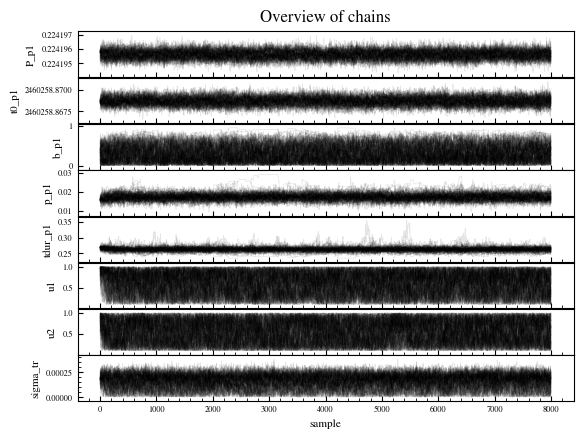

In [242]:
#We use the plot_chains function from the mcmc_help module to plot the chains.
#Note that TF.sampler is equivalent to an emcee.EnsembleSampler object.
mcmc_help.plot_chains(TF.sampler.chain, labels = TF.lpf.ps_vary.labels)

plt.show();

In [243]:
#We can also check the Gelman-Rubin (GR) Statistic to evaluate the chains of each parameter.
#We want the GR statistic to be within 1% of unity => The results should be 1 to 1.01
print("GR Statistics:")
print(50 * "-")
print(mcmc_help.gelman_rubin(chains_after_burnin))
print(50 * "-")

GR Statistics:
--------------------------------------------------
[1.0131306  1.01172066 1.01961185 1.01778461 1.0203499  1.01293796
 1.0146964  1.0120774 ]
--------------------------------------------------


In [244]:
#We can also check the autocorrelation time of the chains.
#If the chain isn't long enough, we would get the following error:
    #The chain is shorter than 50 times the integrated autocorrelation time for x parameter(s).
    #Use this estimate with caution and run a longer chain: N/50 = 40

try:
    print(50 * "-")
    print("Autocorrelation Time")
    print(50 * "-")
    tau = TF.sampler.get_autocorr_time()
    print(tau)

    #We can also divide the length of the chain by the autocorrelation time to get the number of s
    #independent samples.
    print(50 * "-")
    print("Number of Independent Samples")
    print(50 * "-")
    N_eff = len(flatchain) / tau
    print(N_eff)
    print(50 * "-")
    
except Exception as e:
    print("Error calculating the autocorrelation time:", e)
print(50 * "-")


--------------------------------------------------
Autocorrelation Time
--------------------------------------------------
Error calculating the autocorrelation time: The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 160;
tau: [142.00702872 135.10560141 182.45132259 179.728478   161.36759622
 169.14671507 182.7763508  160.35268227]
--------------------------------------------------


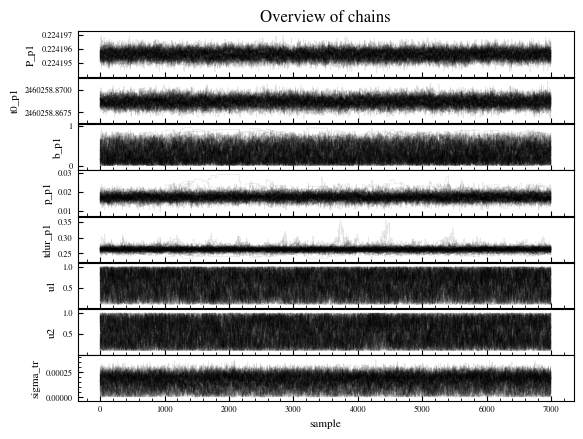

In [245]:
#We can also check how the flatchains look by plotting the flatchains.
mcmc_help.plot_chains(chains_after_burnin, labels = TF.lpf.ps_vary.labels)
plt.show();

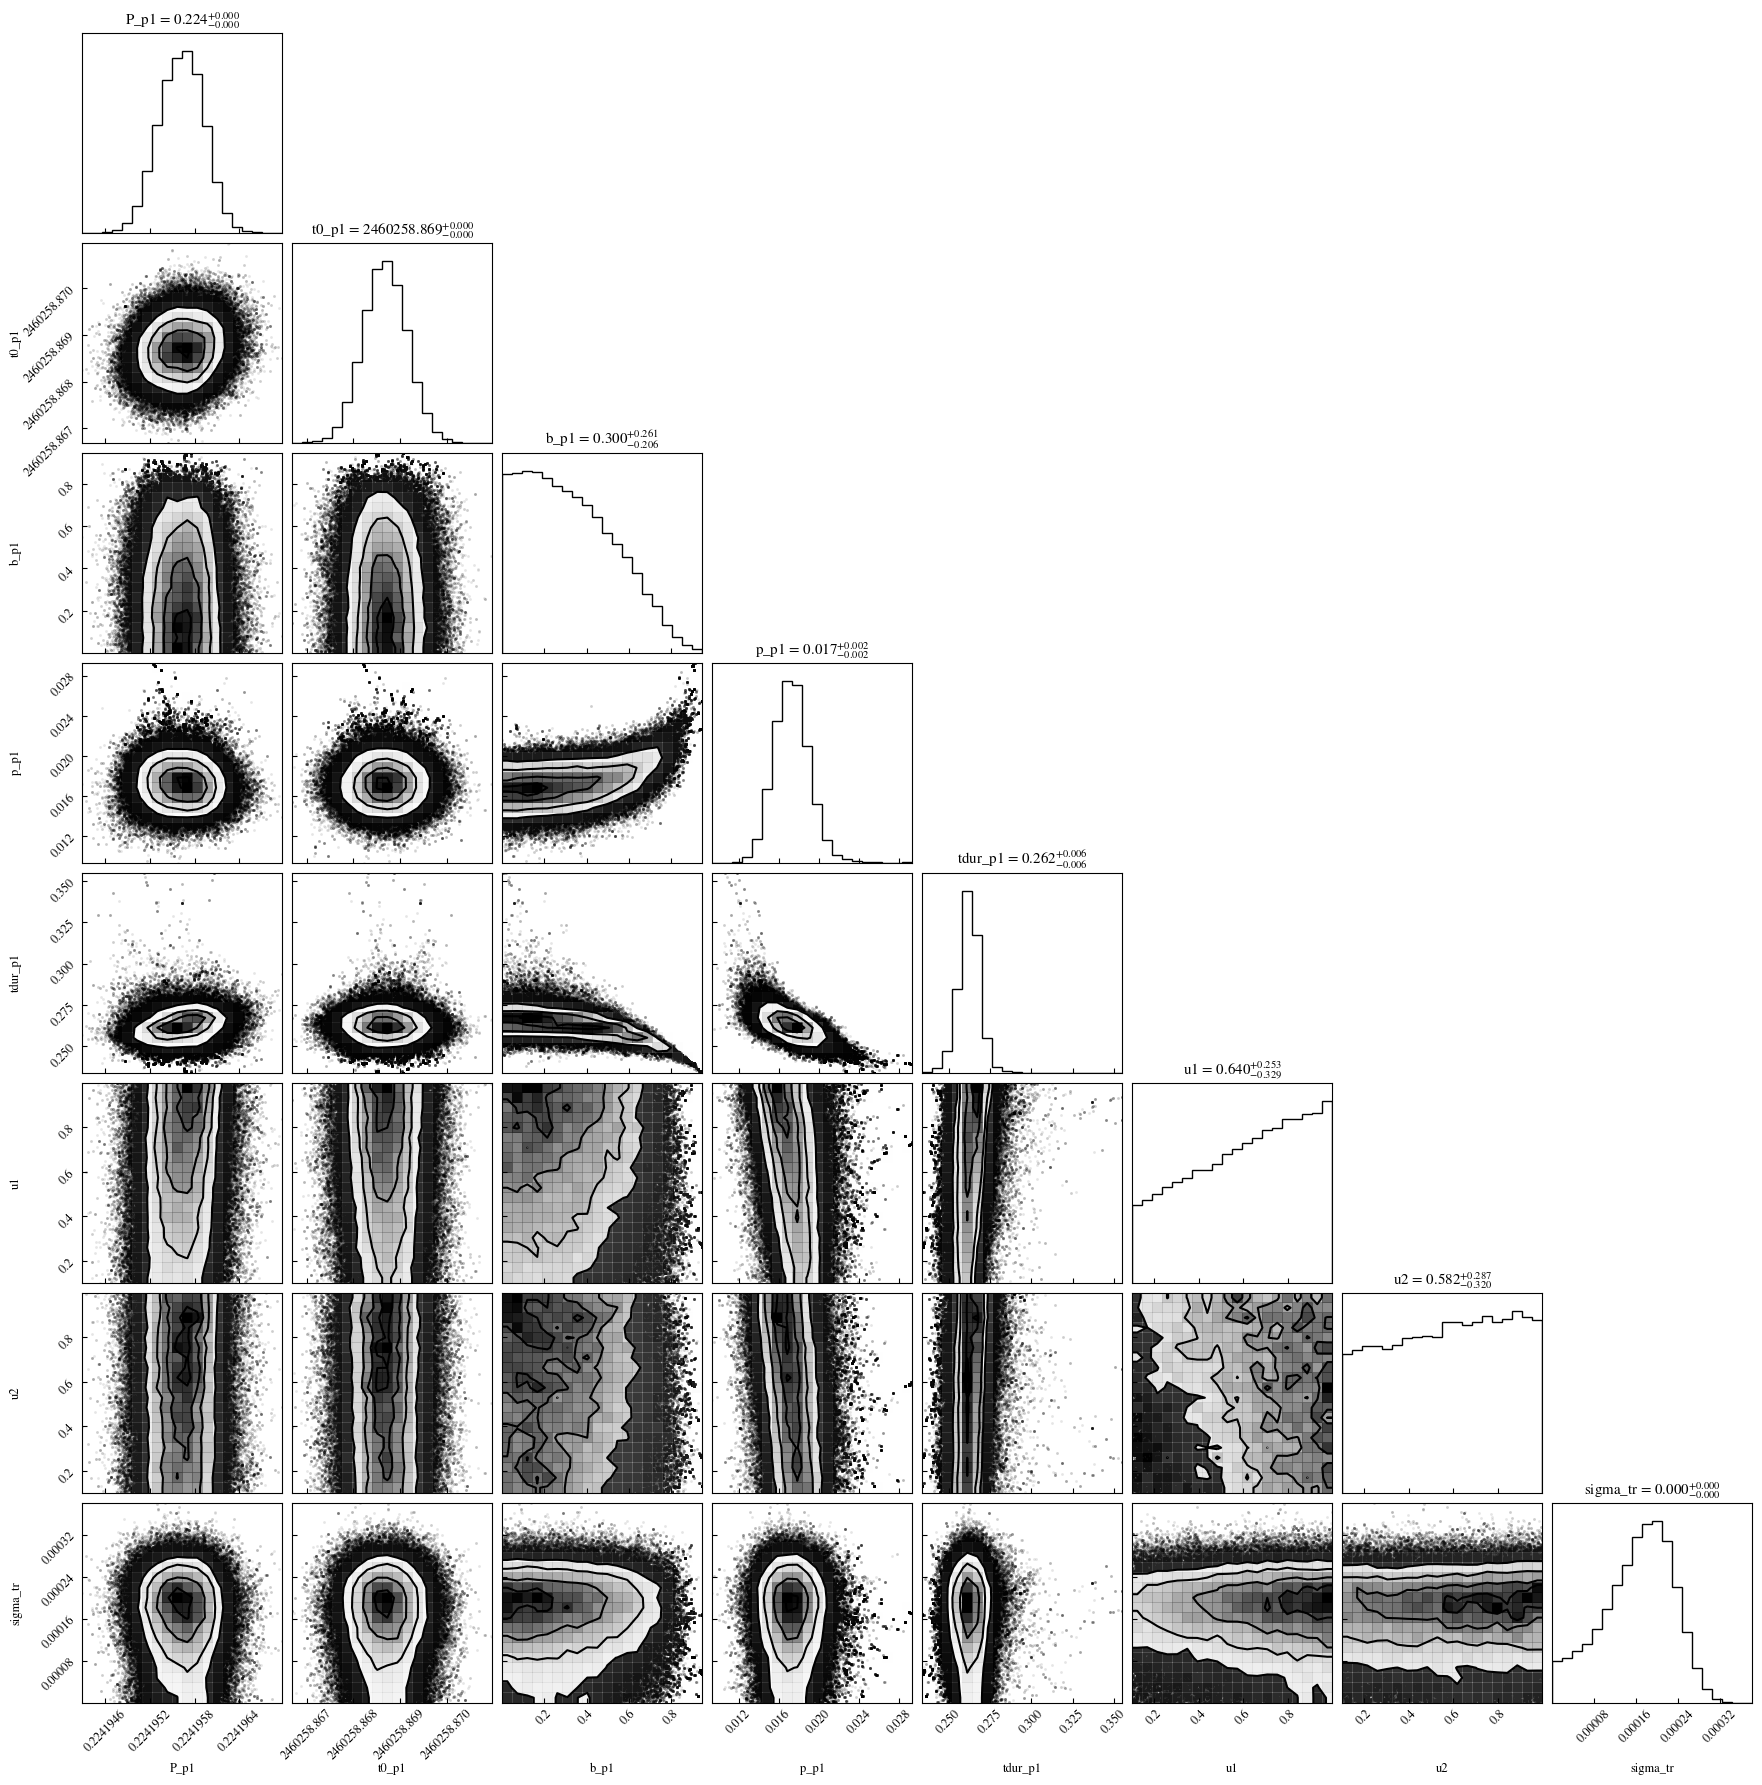

In [246]:
#We can also plot the corner plot to see the correlations and the posterior distributions
#of each parameter that was in the MCMC run.
fig = corner.corner(df_post.iloc[:,:].values,
       show_titles=True,labels=list(df_post.iloc[:,:].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

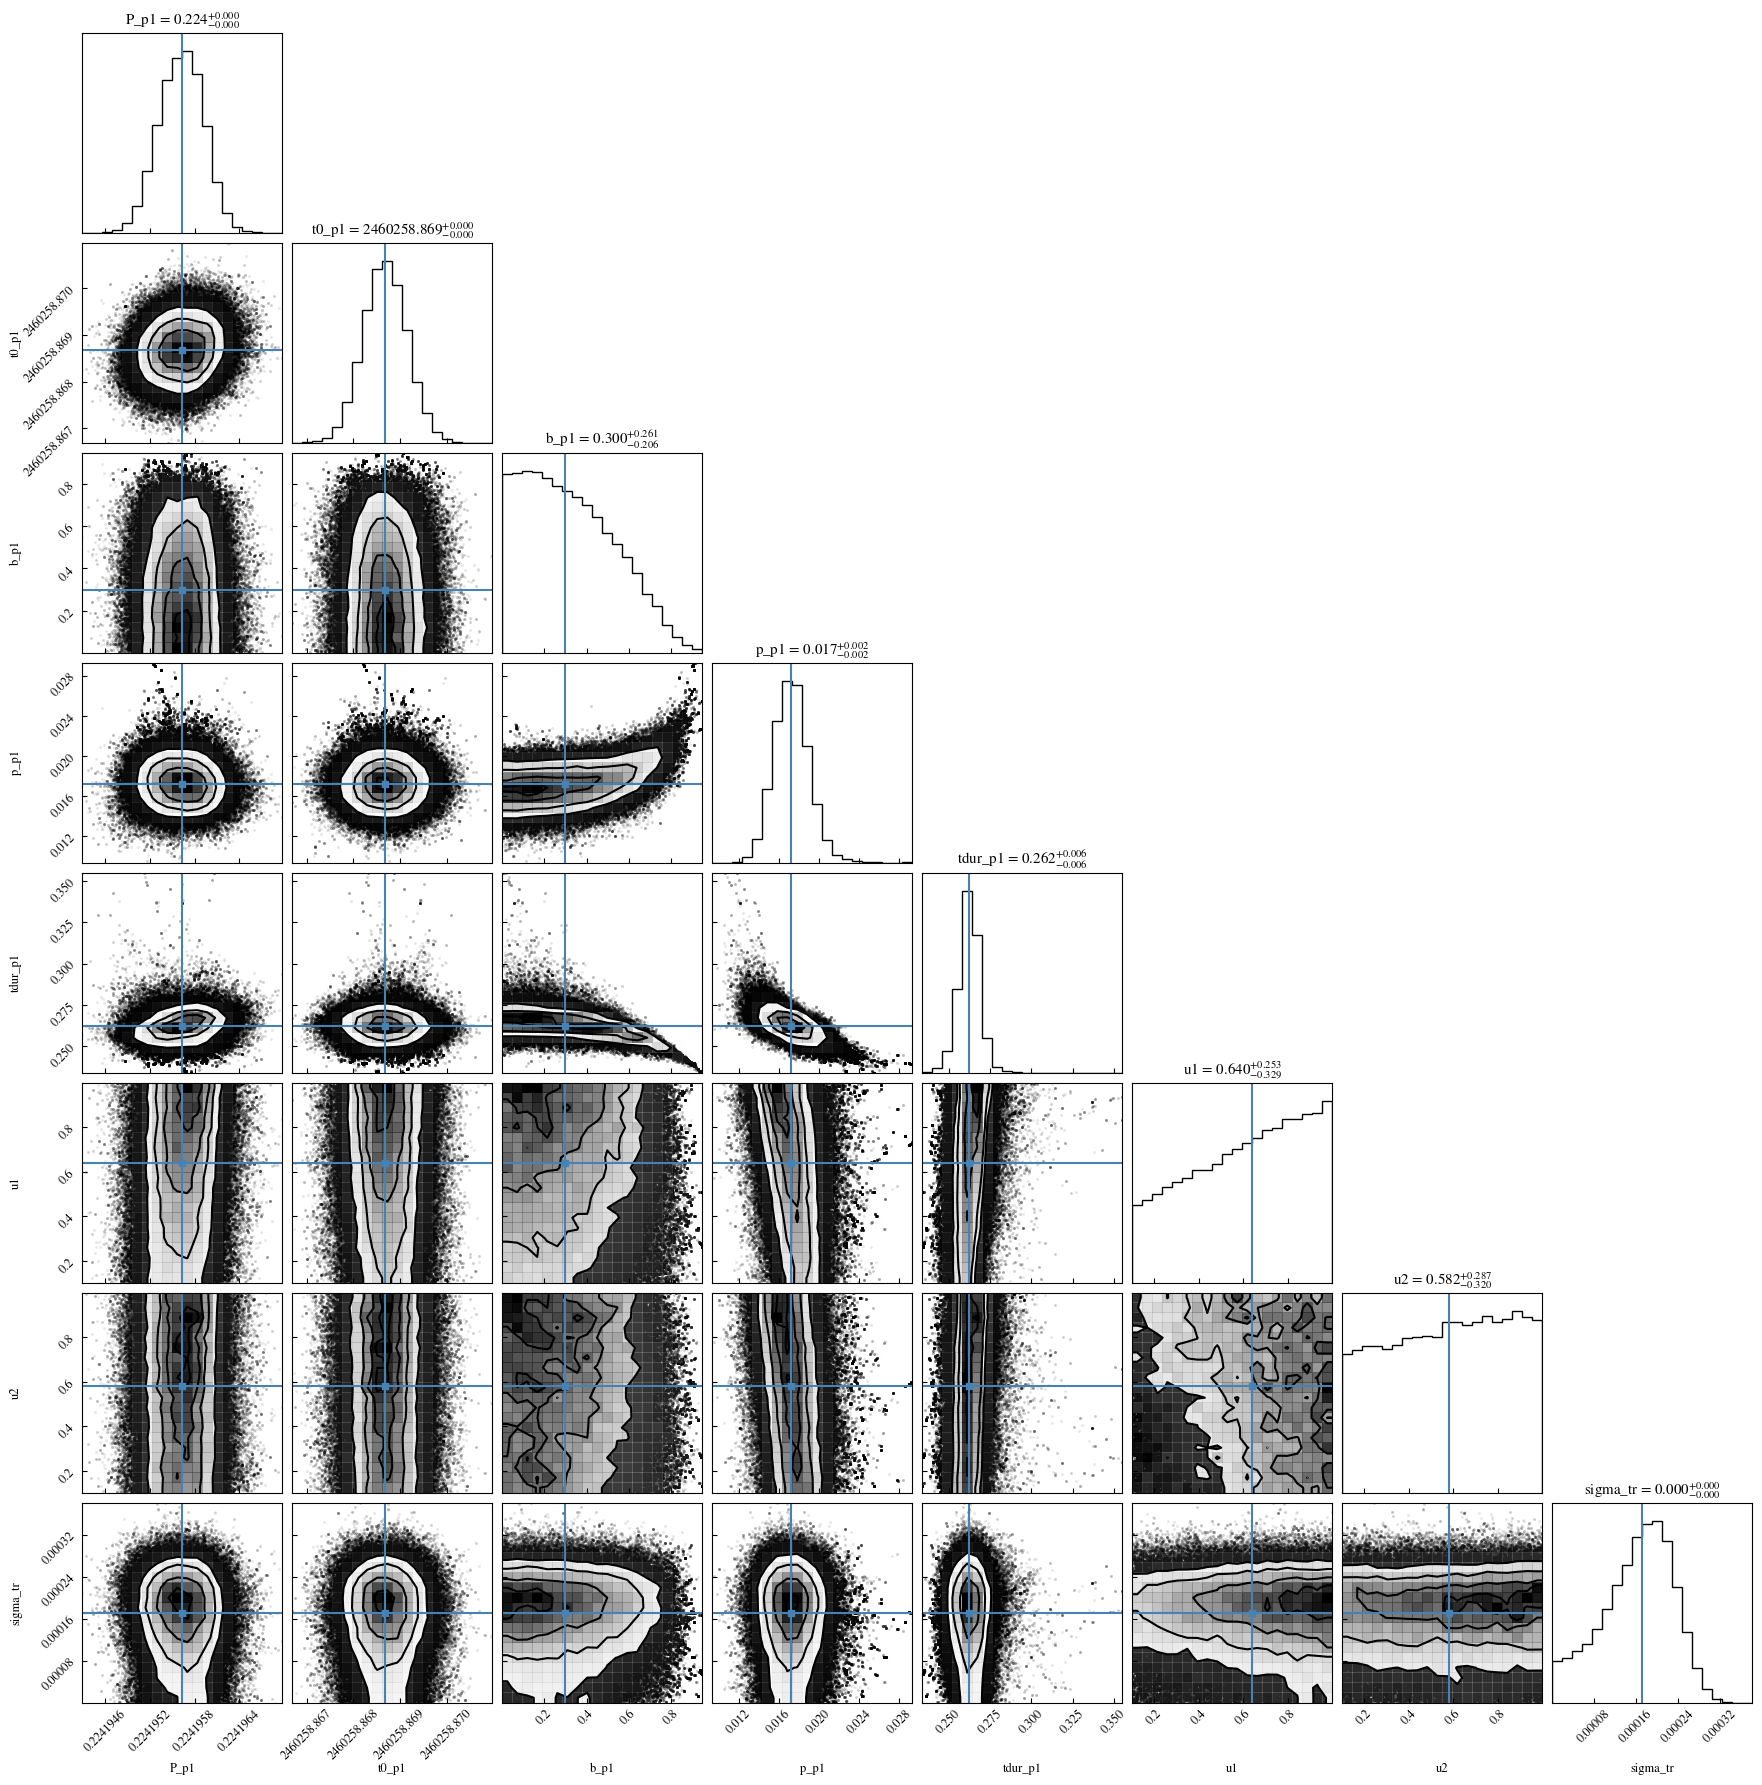

In [247]:
#We can also plot the corner plot with 50th percentile, i.e., the median to see whether
#the posterior distributions are sampled correctly or not.
#We first find the median of each parameter.
pv_50 = np.percentile(flatchain,[50],axis=0)[0]

#We then plot the corner plot and the median.
corner.corner(df_post.iloc[:, :].values,truths=pv_50,
       show_titles=True,labels=list(df_post.iloc[:, :].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

## Working with the Posteriors

In [248]:
#We can obtain the median and uncertainties of each parameter by using the
#.get_mean_values_mcmc_posteriors() function from ExoMUSE_fit.LPFunctionTransitOnly.
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)

df_medvals

medvals         minus          plus  \
0  2.241956e-01  3.078167e-07  2.874316e-07   
0  2.460259e+06  4.557478e-04  4.613376e-04   
0  3.001222e-01  2.057840e-01  2.606628e-01   
0  1.723363e-02  1.673050e-03  1.727921e-03   
0  2.624082e-01  6.011367e-03  5.789558e-03   
0  6.404772e-01  3.285115e-01  2.528255e-01   
0  5.821886e-01  3.202430e-01  2.866818e-01   
0  1.699745e-04  8.044449e-05  5.728918e-05   

                                   values    Labels Description  
0  $0.22419563_{-0.0000003}^{+0.0000003}$      P_p1        P_p1  
0   $2460258.86868_{-0.00046}^{+0.00046}$     t0_p1       t0_p1  
0                   $0.3_{-0.21}^{+0.26}$      b_p1        b_p1  
0            $0.0172_{-0.0017}^{+0.0017}$      p_p1        p_p1  
0            $0.2624_{-0.0060}^{+0.0058}$   tdur_p1     tdur_p1  
0                  $0.64_{-0.33}^{+0.25}$        u1          u1  
0                  $0.58_{-0.32}^{+0.29}$        u2          u2  
0         $0.00017_{-0.00008}^{+0.00006}$  sigma_tr    sigma_tr

In [249]:
df_medvals[["Labels", "values"]]

Labels                                  values
0      P_p1  $0.22419563_{-0.0000003}^{+0.0000003}$
0     t0_p1   $2460258.86868_{-0.00046}^{+0.00046}$
0      b_p1                   $0.3_{-0.21}^{+0.26}$
0      p_p1            $0.0172_{-0.0017}^{+0.0017}$
0   tdur_p1            $0.2624_{-0.0060}^{+0.0058}$
0        u1                  $0.64_{-0.33}^{+0.25}$
0        u2                  $0.58_{-0.32}^{+0.29}$
0  sigma_tr         $0.00017_{-0.00008}^{+0.00006}$

## Plotting the Data and the Best-Fit Model

In [250]:
#We first define the Title and the amount of times we will sample the model.
TITLE = "TOI-2431 Transit-Only Fit"
NUM_SAMPLES = 5000

### Plotting the Data and the Best-Fit Model over Time

In [251]:
#We can first plot the data and the best-fit model over time.
    #Optional: If there we want to convert Julian Dates into Datetimes, i.e. DD-MM-YYYY format,
    #we can use ExoMUSE_utils.jd2datetime(times) function, where times is in Julian Dates.

#For this, we first get the times from our dataset.
times_data = TF.lpf.data["x"]

times_data

array([2459144.52044902, 2459144.52183793, 2459144.52322685, ...,
       2459147.29965555, 2459147.30104446, 2459147.30243336])

In [252]:
#We first get the medians of the parameters by using the flatchain.
#This again can be obtained by checking the 50th percentile of the flatchains.
pv_50 = np.percentile(flatchain, [50], axis=0)[0]

#We then define the amount of times where we will sample the Best-Fit Model.
times_model = np.linspace(times_data.min(), times_data.max(), NUM_SAMPLES)

#We then compute the best-fit model by using the median values and defined times.
tr_model = TF.lpf.compute_total_model(pv_50, times_model)

#We also compute the radial velocity data from the model at the observation times.
tr_data_from_model = TF.lpf.compute_total_model(pv_50, times_data)

#From here, we can calculate the residuals, i.e., DATA - MODEL
residuals = TF.lpf.data["y"] - tr_data_from_model

In [253]:
#We can also plot the uncertainty intervals of our model.
#For this, we can define the following loop that does:
    #1-) Sample a random vector of parameters from the flatchain. E.g. 200th chain
    #2-) Compute the Transit curve using the sampled parameter set/vector.
    #3-) Add this Transit curve model to a list.
    #4-) Sample from this list to get the uncertainty intervals.

#For this we first define a list to store all of the Transit models.
tr_models_for_uncertainty = []

#We then define the loop that does what we described above.
for i in range(NUM_SAMPLES):
    idx = np.random.randint(0, flatchain.shape[0])
    model = TF.lpf.compute_total_model(flatchain[idx], times = times_model)
    tr_models_for_uncertainty.append(model)

#We then convert this list to an array.
tr_models_for_uncertainty = np.array(tr_models_for_uncertainty)

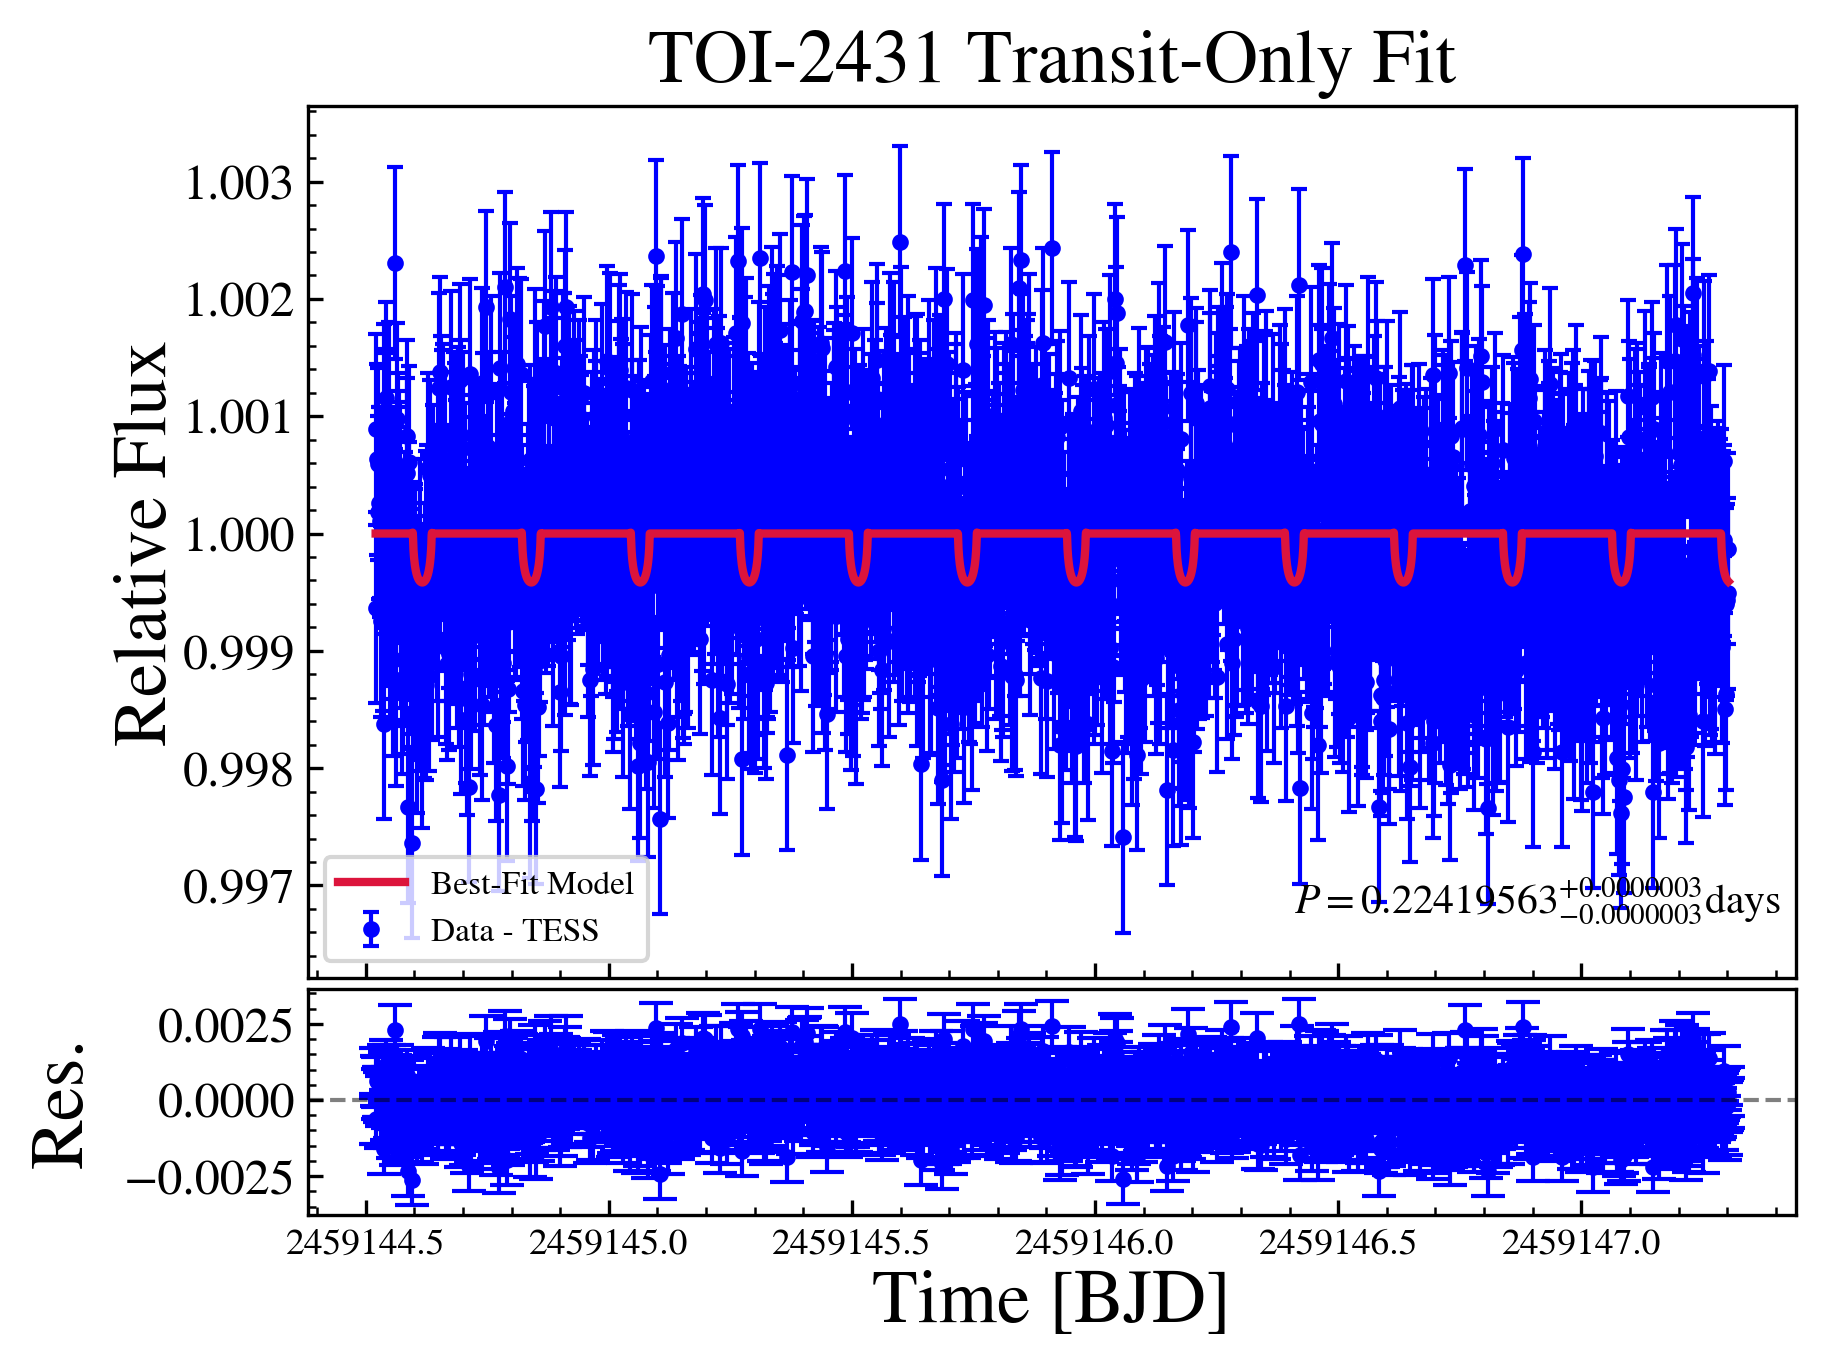

In [254]:
#We then plot our data.
#For this we define 2 rows with one of them for the RV and Best-Fit model, other for the residuals.
fig, (ax, bx) = plt.subplots(dpi = 300, nrows = 2, gridspec_kw = {"height_ratios": [5, 1.3]}, sharex = True)

#Optional: We can also put some of the parameter values onto our plots.
#For this, we can do the following.
label_params = "$P=${}".format(df_medvals[df_medvals.Labels=="P_p1"]["values"].values[0])+"days\n"

#We can also add the model of RV uncertainties into the datapoints.
    #uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_rv"].values[0]

#In this fit, it was varied.
uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_tr"].values[0]
inflated_tr_err = np.sqrt(pow(TF.lpf.data["error"], 2) + pow(uncertainty_sigma, 2))

#We define errorbars and the datapoints.
    #Optional: If needed, times can be put into ExoMUSE_utils.jd2datetime(times) during plotting
    #for the plot to be in DateTime format.
ax.errorbar(TF.lpf.data["x"], TF.lpf.data["y"], yerr = inflated_tr_err,
            marker='.', elinewidth=1, capsize=2, lw=0, mew=1, color="blue",
            markersize=6, label='Data - TESS', zorder = -100)

#We also plot our best-fit model.
ax.plot(times_model, tr_model, color="crimson", label = "Best-Fit Model", lw=2., zorder=10)

#We then plot the residuals.
bx.errorbar(TF.lpf.data["x"], residuals, yerr = inflated_tr_err,
            marker='.', elinewidth=1, capsize=4, lw=0, mew=1, color="blue",
            markersize=6, zorder = -100)

#Optional: We add the parameter values onto the bottom-right of the RV graph (first row).
ax.text(0.99, 0.01, label_params, va = 'bottom', ha = 'right', fontsize=10, transform=ax.transAxes)

#We plot the uncertainty intervals by using tr_models_for_uncertainty.
#1 Sigma Interval
# ax.fill_between(times_model, 
#                 np.percentile(tr_models_for_uncertainty, 16, axis=0),
#                 np.percentile(tr_models_for_uncertainty, 84, axis=0),
#                 color='#EE2C2C', alpha=0.3)
# #2 Sigma Interval
# ax.fill_between(times_model, 
#                 np.percentile(tr_models_for_uncertainty, 2, axis=0),
#                 np.percentile(tr_models_for_uncertainty, 98, axis=0),
#                 color='#EE2C2C', alpha=0.2)
# #3 Sigma Interval
# ax.fill_between(times_model, 
#                 np.percentile(tr_models_for_uncertainty, 0.15, axis=0),
#                 np.percentile(tr_models_for_uncertainty, 99.85, axis=0),
#                 color='#EE2C2C', alpha=0.1)

#We then set the labels and titles for the plot.
ax.set_ylabel('Relative Flux',labelpad=0,fontsize=18)
bx.set_xlabel('Time [BJD]',labelpad=2,fontsize=18)
bx.set_ylabel('Res.',labelpad=6,fontsize=18)

#We get the x limit and then set a new limit.
xlim = ax.get_xlim()
ax.set_xlim(xlim[0],xlim[1])

#We do the same for y limit.
ylim = ax.get_ylim()
ax.set_ylim(ylim[0]+0, ylim[-1]+0)

#We define additional times to plot the zero-line for residuals.
time_res = np.linspace(xlim[0],xlim[-1],100)
bx.plot(time_res,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We set 0.02 horizontal space between 2 rows of plots.
fig.subplots_adjust(hspace=0.02)

#We apply the settings to the axes.
for xx in [ax,bx]:
    ExoMUSE_utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis = 'x', labelsize = 9)
ax.set_title(TITLE, fontsize = 18)
ax.legend(loc = "lower left", fontsize = 8)

plt.show();

### Plotting the Data and the Best-Fit Model over Phase

In [255]:
#To plot the Data and the Best-Fit model over Phase, we first need to get the Period and T0
#from the flatchains.
P = df_medvals["medvals"][df_medvals["Labels"] == "P_p1"].values[0]
T_0 = df_medvals["medvals"][df_medvals["Labels"] == "t0_p1"].values[0]

#We can then use ExoMUSE_utils.time_to_phase(times, P, T0) function to convert the times
#to phase.
phase_data = ExoMUSE_utils.time_to_phase(times_data, P, T_0, phase_method="centered")

#We then convert the model times to phase too.
phase_model = ExoMUSE_utils.time_to_phase(times_model, P, T_0, phase_method="centered")

#We then have to sort the data according to the Phase values we have.
sorted_indices = np.argsort(phase_model)
phase_model_sorted = phase_model[sorted_indices]
tr_model_sorted = tr_model[sorted_indices]

In [256]:
#We can again the uncertainty intervals of our model.
#It is the same structure as before.

#For this we first define a list to store all of the Transit models.
tr_models_for_uncertainty_phase = []

#We then define the loop that does what we described above.
for i in range(NUM_SAMPLES):
    idx = np.random.randint(0, flatchain.shape[0])
    model = TF.lpf.compute_total_model(flatchain[idx], times = times_model)
    model_sorted = model[sorted_indices]
    tr_models_for_uncertainty_phase.append(model_sorted)

#We then convert this list to an array.
tr_models_for_uncertainty_phase = np.array(tr_models_for_uncertainty_phase)

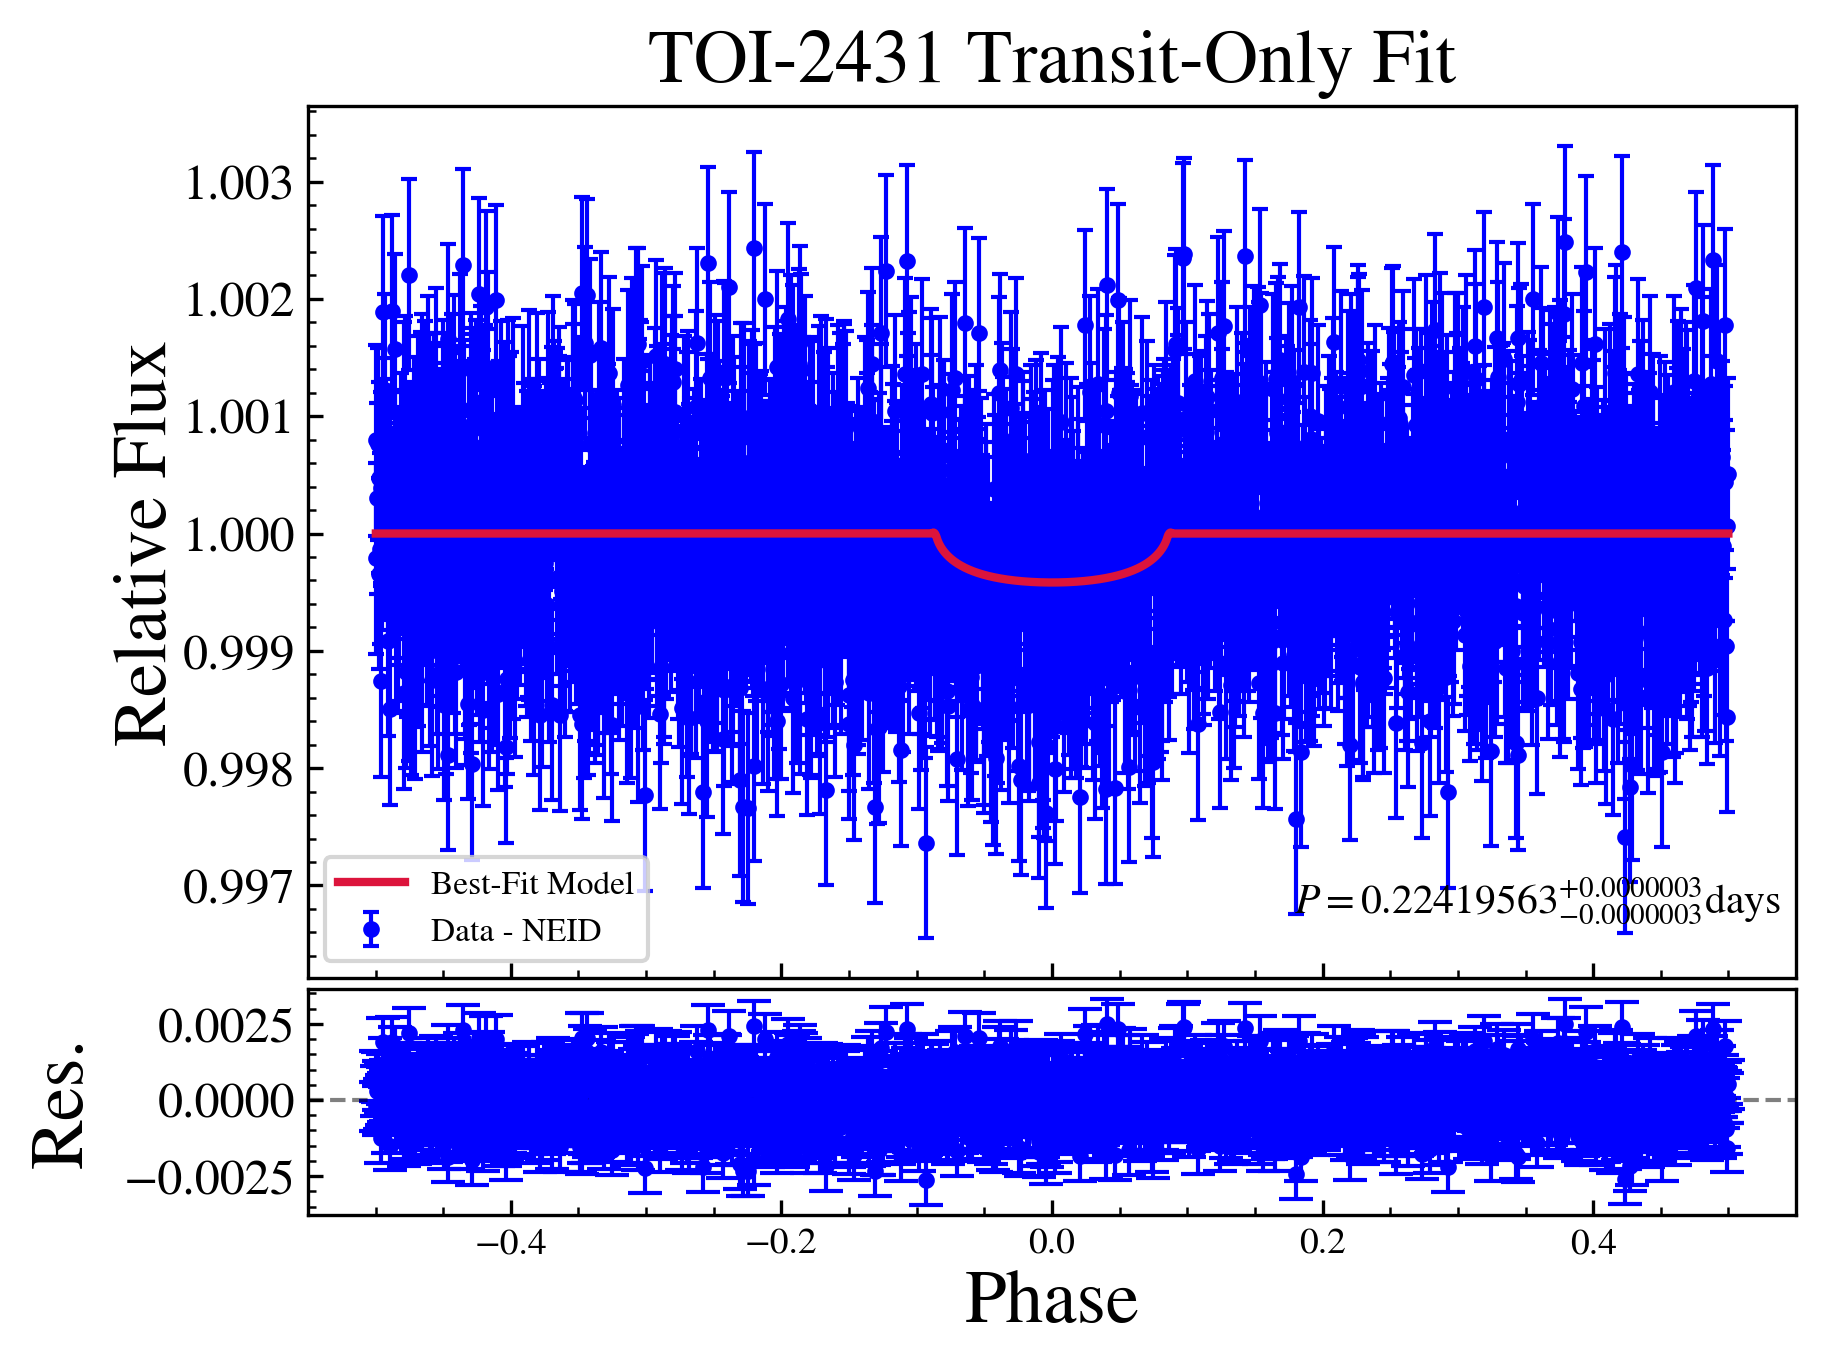

In [257]:
#We can then again plot the data as follows.
#We then plot our data.
#For this we define 2 rows with one of them for the Flux and Best-Fit model, other for the residuals.
fig, (ax, bx) = plt.subplots(dpi = 300, nrows = 2, gridspec_kw = {"height_ratios": [5, 1.3]}, sharex = True)

#Optional: We can also put some of the parameter values onto our plots.
#For this, we can do the following.
label_params = "$P=${}".format(df_medvals[df_medvals.Labels=="P_p1"]["values"].values[0])+"days\n"

#We can also add the model of Flux uncertainties into the datapoints.
    #uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_tr"].values[0]

#In this fit, it was varied.
uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_tr"].values[0]
inflated_tr_err = np.sqrt(pow(TF.lpf.data["error"], 2) + pow(uncertainty_sigma, 2))

#We define errorbars and the datapoints.
    #Optional: If needed, times can be put into ExoMUSE_utils.jd2datetime(times) during plotting
    #for the plot to be in DateTime format.
ax.errorbar(phase_data, TF.lpf.data["y"], yerr = inflated_tr_err,
            marker='.', elinewidth=1, capsize=2, lw=0, mew=1, color="blue",
            markersize=6, label='Data - NEID', zorder = -10)

#We also plot our best-fit model.
ax.plot(phase_model_sorted, tr_model_sorted, color="crimson", label = "Best-Fit Model", lw=2., zorder=10)

#We then plot the residuals.
bx.errorbar(phase_data, residuals, yerr = inflated_tr_err,
            marker='.', elinewidth=1, capsize=4, lw=0, mew=1, color="blue",
            markersize=6, zorder = -10)

#Optional: We add the parameter values onto the bottom-right of the Transit graph (first row).
ax.text(0.99, 0.01, label_params, va = 'bottom', ha = 'right', fontsize=10, transform=ax.transAxes)

#We plot the uncertainty intervals by using tr_models_for_uncertainty_phase.
#1 Sigma Interval
# ax.fill_between(phase_model_sorted, 
#                 np.percentile(tr_models_for_uncertainty_phase, 16, axis=0),
#                 np.percentile(tr_models_for_uncertainty_phase, 84, axis=0),
#                 color='#EE2C2C', alpha=0.3)
# #2 Sigma Interval
# ax.fill_between(phase_model_sorted, 
#                 np.percentile(tr_models_for_uncertainty_phase, 2, axis=0),
#                 np.percentile(tr_models_for_uncertainty_phase, 98, axis=0),
#                 color='#EE2C2C', alpha=0.2)
# #3 Sigma Interval
# ax.fill_between(phase_model_sorted, 
#                 np.percentile(tr_models_for_uncertainty_phase, 0.15, axis=0),
#                 np.percentile(tr_models_for_uncertainty_phase, 99.85, axis=0),
#                 color='#EE2C2C', alpha=0.1)

#We then set the labels and titles for the plot.
ax.set_ylabel('Relative Flux',labelpad=0,fontsize=18)
bx.set_xlabel('Phase',labelpad=2,fontsize=18)
bx.set_ylabel('Res.',labelpad=6,fontsize=18)

#We get the x limit and then set a new limit.
xlim = ax.get_xlim()
ax.set_xlim(xlim[0],xlim[1])

#We do the same for y limit.
ylim = ax.get_ylim()
ax.set_ylim(ylim[0]+0, ylim[-1]+0)

#We define additional times to plot the zero-line for residuals.
time_res = np.linspace(xlim[0],xlim[-1],100)
bx.plot(time_res,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We set 0.02 horizontal space between 2 rows of plots.
fig.subplots_adjust(hspace=0.02)

#We apply the settings to the axes.
for xx in [ax,bx]:
    ExoMUSE_utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis = 'x', labelsize = 9)
ax.set_title(TITLE, fontsize = 18)
ax.legend(loc = "lower left", fontsize = 8)

plt.show();

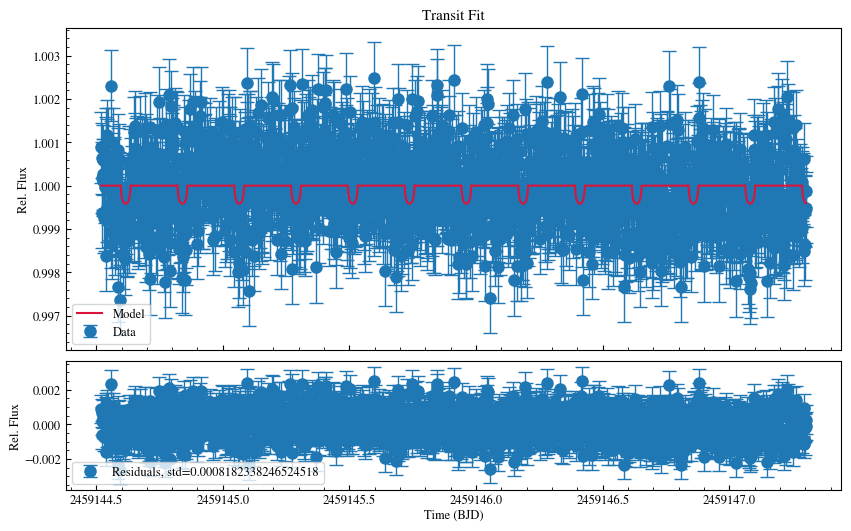

In [258]:
#If needed, it is also possible to quickly plot the best-fit model with a simple function inside ExoMUSE_fit.
    #pv: Parameter Values, add medial values.
    #times: Times that we want to evaluate the model on.
quick_plot = TF.plot_fit(pv = df_medvals["medvals"].values, times=times_model)
plt.show()